In [3]:
%load_ext autoreload
%autoreload 2
!pip install -r requirements.txt

import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import clear_output, Image


import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
import warnings
warnings.filterwarnings("ignore")

from envs.bandit import Bandit
from envs.context_bandit import ContextualBandit, get_state_probs
from envs.frozen_lake import FrozenLakeEnv

from utils import *
from value_iteration import *
from mcts import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# The Bitter Lesson

Rich Sutton, one of the pioneers of modern reinforcement learning, detailed an account of the ["Bitter Lesson"](http://www.incompleteideas.net/IncIdeas/BitterLesson.html) of machine learning. 
               
In short, he speaks of the power of computation-driven learning. Over the almost 100 years of serious AI research that has happened so much effort has been put into distilling human knowledge down to core concepts or primitives that we can give to machines to make them intelligent. Time and time again, the biggest breakthoughs in ML/AI have not been in perfect representations of knowledge or heuristics about how to learn, but in leveraging computation resources available to allow these software agents to discover the structure in the problems themselves.

## Learning without Knowledge

The purpose of this session is to show some techiques we have under our belt to tackles problems without incorporating knowledge of the process we want to learn. While using heuristics or priors can great speed up learning on certain problems, we want to show in general we can learn in the most efficient way possible without any of that.

We will structure this post into 3 parts:

* Stateless, only your actions yield outcomes across independent trails
* Stateful, your actions yield outcomes in a context across independent trials
* Stateful, your actions yield outcomes in a context over time

This allows us to tackle problems with minimum information about the world first, see how we would solve them, and then modify our policies when we have more information to take advantage.


## Part 1: Bandits



![Bandit](assets/multi_armed_bandit.png)

- MDP with no state
- we want to minimize the total regret (how much reward you lost by not selecting optimal action up to time T)

### Regret





In [ ]:
"""
Let's play around with a bandit to see what the problem is like. You can change any of the variables below
to modify how many arms there are or the likelihoods of arms giving reward. Once you run this cell, you will be 
able to interact with some buttons to produce plots on how well you are doing.
"""
n_arms = 8

# Setup some random arm probabilities
bad_arm_prob = 0.3
good_arm_prob = 0.8
regret = good_arm_prob - bad_arm_prob
probs = np.zeros(n_arms) + bad_arm_prob
probs[np.random.choice(range(n_arms))] = good_arm_prob

# Configure environment
config = {"num_arms" : n_arms, "probs": probs}
env = Bandit(config)

# Create fancy UI
buttons = [widgets.Button(description=f'Arm: {i}') for i in range(n_arms)]
cumulative_reward = [0]
def press(button):
    ## Sanitize inputs, clear current output
    clear_output()
    value = int(button.description.split(" ")[1])
    
    ## Step env, keep track of cumulative reward each step
    r = env.step(value)
    cumulative_reward.append(env.cumulative_reward.sum())
    print(f"Reward: {r}, Total steps: {env.visits.sum()}")
    
    ## plot
    fig, axs = plt.subplots(1, 3, figsize=(15, 8))
    plot_avg_reward(axs[0], env)
    plot_cumulative_reward(axs[1], cumulative_reward)
    plot_cumulative_regret(axs[2], regret, env)

    plt.legend()
    fig.tight_layout()
    
    display(buttons)

[buttons[i].on_click(press) for i in range(n_arms)]
buttons = widgets.HBox(buttons)
display(buttons)

## Solving bandit problems

- **information state search**: exploration provides information which can increase expected reward in future 
- optimal solutions can be found by solving infinte-state MDP over info states
- need heuristics to make things tractable

bandit strategies scale with how we handle uncertainty:

- no exploration, just greedily pull best values we have seen in past
- random exploration
- explore with preference towards uncertaint

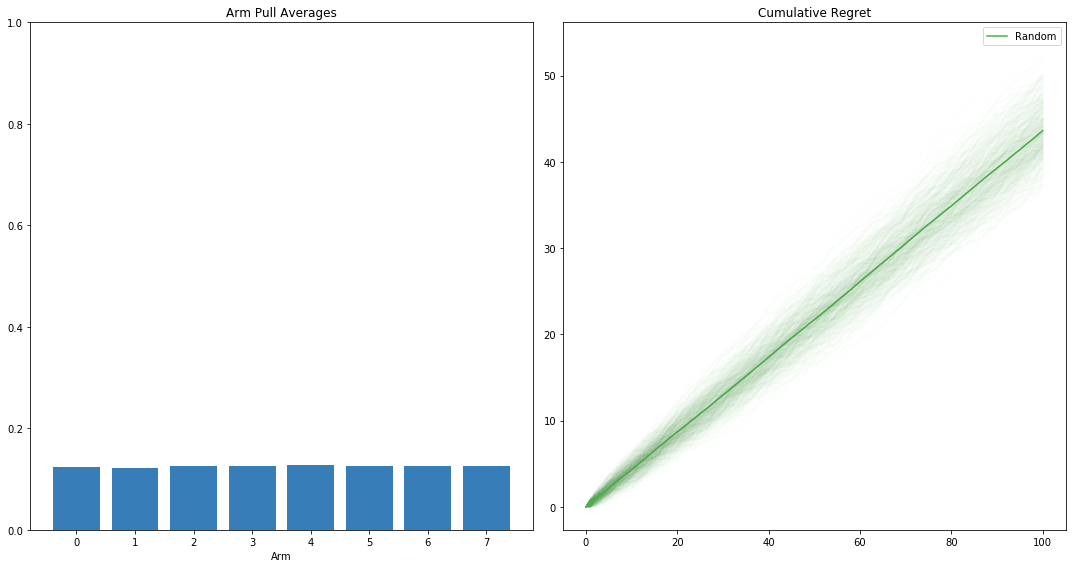

In [5]:
n_steps = 100
n_trials = 500
n_arms = 8
config = {"num_arms" : n_arms, "probs": (1/n_arms) * np.arange(n_arms)}
env = Bandit(config)

def random_selection(env):
    return np.random.randint(env.n_arms)

random = run_simulation(random_selection, env, n_steps=n_steps, n_trials=n_trials)
plot_simulation([random[1]], random[0], env)
plt.show()

### $\epsilon$-Greedy Algorithm

action value is just average of rewards we have seen over time

e-Greedy just selects the non-max at random sometimes


In [6]:
def e_greedy_selection(env, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(env.n_arms)
    else:
        return np.argmax(env.arm_avgs())
    
def create_egreedy(epsilon):
    return lambda env: e_greedy_selection(env, epsilon)

def update(epsilon):
    global egreedy
    selection = create_egreedy(epsilon)
    egreedy = run_simulation(selection, env, n_steps=n_steps, n_trials=n_trials)
    plot_simulation([random[1], egreedy[1]], egreedy[0], env)
    plt.show()

interact_manual(update, epsilon=widgets.FloatSlider(min=0, max=1, step=0.05))

interactive(children=(FloatSlider(value=0.0, description='epsilon', max=1.0, step=0.05), Button(description='R…

<function __main__.update(epsilon)>

### UCB Algorithm

e-Greedy not awesome because a lot of the time we end up exploring bad actions that we sort of know will not yield anything great

The idea is to agument the value function with an upper bound on the reward value so that the true reward value is lower: $Q(a) \leq \hat{Q}_t(a) + \hat{U}_t(a)$.

Hoeffding's inequality can be used if we do not want to assign any prior to the distribution of rewards, works for any bounded distribution. 

$$P[\frac{1}{n} \sum_{i =1}^{n}(Z_i - E[Z_i]) \geq \delta\ ] \leq e^{- \frac{2n\delta^2}{(b - a)^2}}$$

So we view this average of the random variable $Z_i$ as the averaged reward of a particular action, $\hat{Q_t}(a) = \frac{1}{n} \sum_{t=0}^n R_i$. The inequality then gets written as (with $t = N_t(a)$, the number of times this action has been visited): 

$$P[Q_t - \hat{Q_t} \geq \delta ] \leq e^{-\frac{2N_t(a)\delta^2}{(b-a)^2}}$$

We see that then our upper bound on the true reward can be given by $\delta = \hat{U_t}(a)$. And if we make the simplifying assumption that the reward is bounded to be on the interval $(0, 1)$. We can then for any value of the probability of deviation, $p$, we can solve for what we expect the upper bound on that deviation to be:

$$
p \approx e^{-2N_t(a)U_t(a)^2} \\
U_t(a) = \sqrt{\frac{- \log p}{2 N_t (a)}}
$$

Most of the time in practice, we use a heuristic to drop this $p$ over time, typically $p=t^{-4}$.

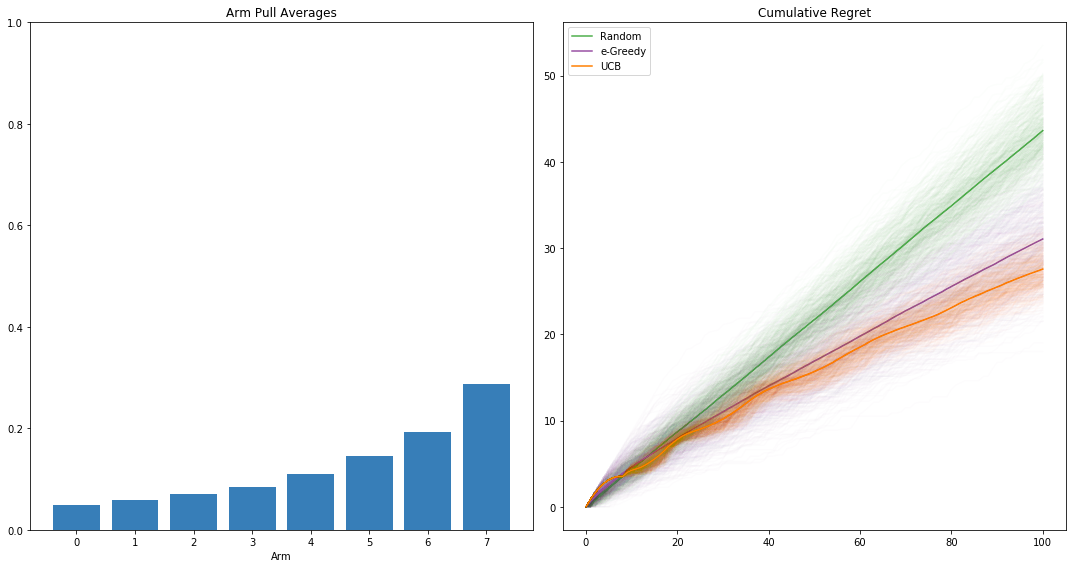

In [7]:
def ucb_selection(env):
    ucb = np.sqrt((2 * np.log(env.visits.sum())) / env.visits)
    mod_avgs = env.arm_avgs() + ucb
    return np.argmax(mod_avgs)

ucb = run_simulation(ucb_selection, env, n_steps=n_steps, n_trials=n_trials)
plot_simulation([random[1], egreedy[1], ucb[1]], ucb[0], env)
plt.show()

## Contextual Bandits

The next class of environments we will look at are referred to as "Contexual" bandit problems. This refers to an observation we get to perform before choosing our action. The observation allows us to have "context" of the situation to use in choosing a useful action.

Examples of these types of problems are very common in recommender systems. We can think of a user having a context (or in a profile) that we can review before making a decision as to what ad we should serve or movie we can recommend.

In [ ]:
"""
Let's play around with a bandit to see what the problem is like. You can change any of the variables below
to modify how many arms there are or the likelihoods of arms giving reward. Once you run this cell, you will be 
able to interact with some buttons to produce plots on how well you are doing.
"""
n_arms = 8

n_arms = 2
n_states = 2

## Red: arm 1, Green: arm 0
state_probs = np.array([[0.1, 0.9], [0.9, 0.1]])
# state_probs = get_state_probs(n_states, n_arms)
config = {
    "num_arms" : n_arms,
    "num_states" : n_states,
    "state_probs": state_probs
}
env = ContextualBandit(config)

# Create fancy UI
buttons = [widgets.Button(description=f'Arm: {i}') for i in range(n_arms)]
cumulative_reward = [0]
def press(button):
    ## Sanitize inputs, clear current output
    clear_output()
    value = int(button.description.split(" ")[1])
    
    ## Step env, keep track of cumulative reward each step
    s, r = env.step(value)
    cumulative_reward.append(env.cumulative_reward.sum())

    # Use a colored box to show context
    if (s == 0):
        box = widgets.HTML(value="<div style='background-color: green ; padding: 10px; border: 1px solid green;'>")
    else: 
        box = widgets.HTML(value="<div style='background-color: red ; padding: 10px; border: 1px solid red;'>")
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 8))

    # State, action visitation
    action_norm = env.visits.sum(axis=1, keepdims=True)
    sns.heatmap(env.visits / action_norm, cmap="Blues", ax=axs[0], vmax=1, vmin=0, cbar=False, annot=True, xticklabels=np.arange(env.n_arms))
    axs[0].set_title("Arm averages")
    axs[0].set_ylabel("State/Context")
    axs[0].set_xlabel("Arm")
    axs[0].set_yticklabels(["Red", "Green"])

    plot_cumulative_reward(axs[1], cumulative_reward)
    
    cumulative_r = np.cumsum(env.regret)
    steps = np.arange(len(cumulative_r))
    axs[2].plot(steps, cumulative_r, label="You")
    axs[2].plot(steps, 0.8 * steps, label="Random")
    axs[2].set_title("Regret over time")
    
    fig.tight_layout()
    display(buttons)
    display(box)

[buttons[i].on_click(press) for i in range(n_arms)]
buttons = widgets.HBox(buttons)
display(buttons)

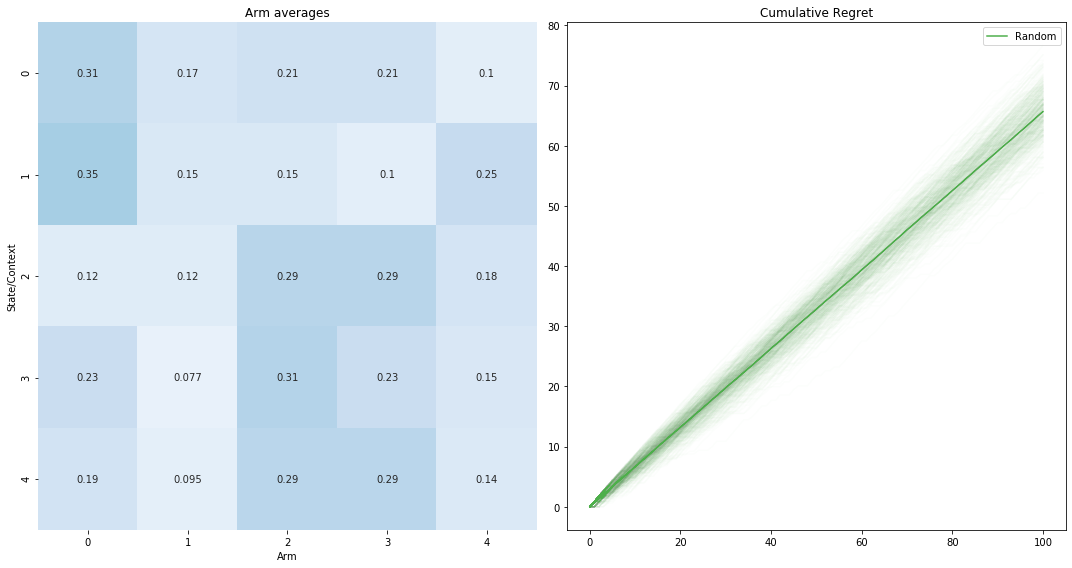

In [10]:
import numpy as np

from envs.context_bandit import *
from utils import *

n_steps = 100
n_trials = 500
n_arms = 5
n_states = 5
# state_probs = np.array([[0.1, 0.9], [0.9, 0.1]])
state_probs = get_state_probs(n_states, n_arms)
config = {
    "num_arms" : n_arms,
    "num_states" : n_states,
    "state_probs": state_probs
}

env = ContextualBandit(config)
def random_selection(env):
    return np.random.randint(env.n_arms)

random = run_simulation(random_selection, env, n_steps=n_steps, n_trials=n_trials)
plot_contextual_simulation([random[1]], random[0], env)
plt.show()

In [11]:
def e_greedy_selection(env, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(env.n_arms)
    else:
        return np.argmax(env.arm_avgs(env.state))

def create_egreedy(epsilon):
    return lambda env: e_greedy_selection(env, epsilon)

def update(epsilon):
    global egreedy
    selection = create_egreedy(epsilon)
    egreedy = run_simulation(selection, env, n_steps=n_steps, n_trials=n_trials)
    plot_contextual_simulation([random[1], egreedy[1]], egreedy[0], env)
    plt.show()

interact_manual(update, epsilon=widgets.FloatSlider(min=0, max=1, step=0.05))

interactive(children=(FloatSlider(value=0.0, description='epsilon', max=1.0, step=0.05), Button(description='R…

<function __main__.update(epsilon)>

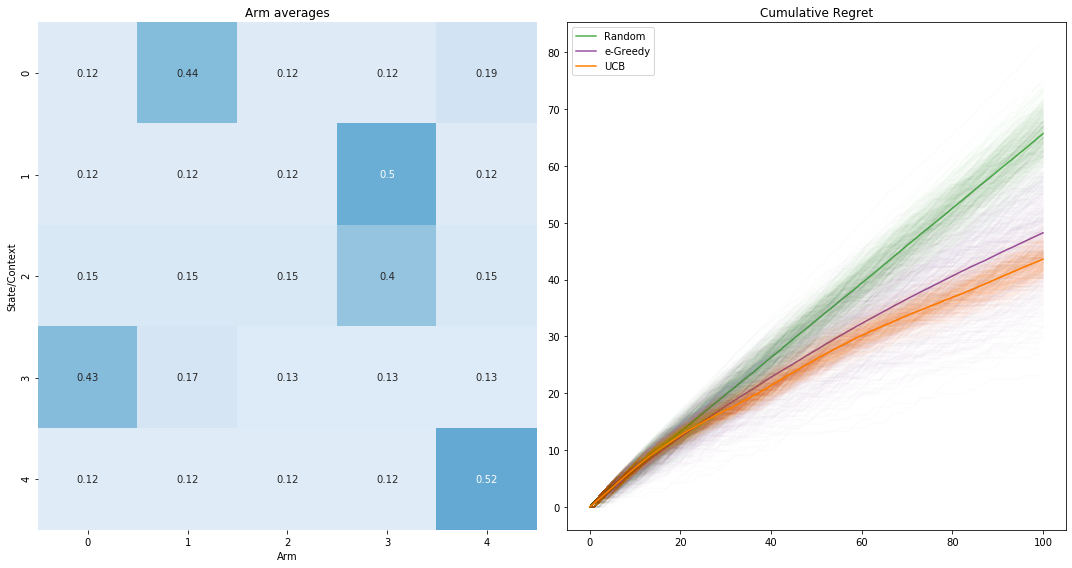

In [12]:
def ucb_selection(env):
    ucb = np.sqrt((2 * np.log(env.visits[env.state, :].sum())) / env.visits[env.state, :])
    mod_avgs = env.arm_avgs(env.state) + ucb
    return np.argmax(mod_avgs)

ucb = run_simulation(ucb_selection, env, n_steps=n_steps, n_trials=n_trials)
plot_contextual_simulation([random[1], egreedy[1], ucb[1]], ucb[0], env)
plt.show()

# Modern Monte Carlo Tree Search

How can we efficiently search without relying on expert knowledge?

- **exploration**: learn values of actions we are uncertain about
- **exploitation**: focus search on promising parts of tree



## Markov Decision Processes (MDPs)

We have been building up the problem description in a more and more complex manner over the course of this presentation.

Our agents have only seen a state, took an action, and then recieved a reward for how they acted. There was no notion of time in any of these algorithms and so the agents actions had no effect on the future. Real decision making processes have some degree of effect on the payoff you get. We can model these systems with MDPs.

MDPs are a pretty general framework for dealing with decision making over some sort of horizon (possibly even infinite).



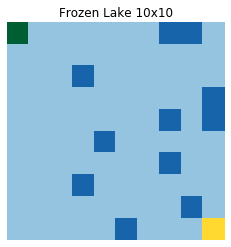

In [13]:
env = FrozenLakeEnv(10)
state = env.reset()
env.render()

## Value Functions

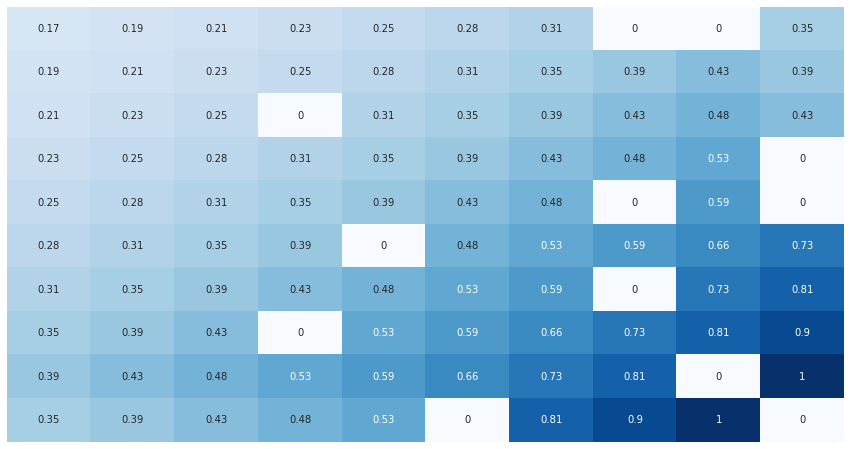

In [14]:
value_fcn = value_iteration(env, gamma=0.9)
plot_value_function(value_fcn, env)

Move RIGHT


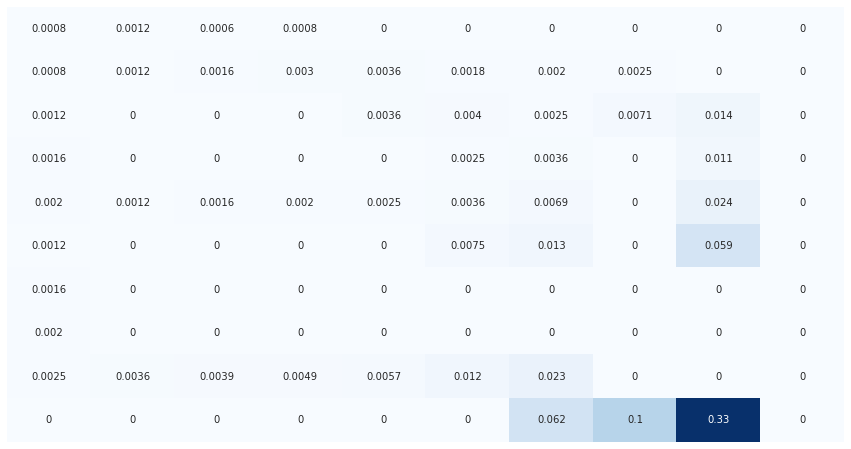

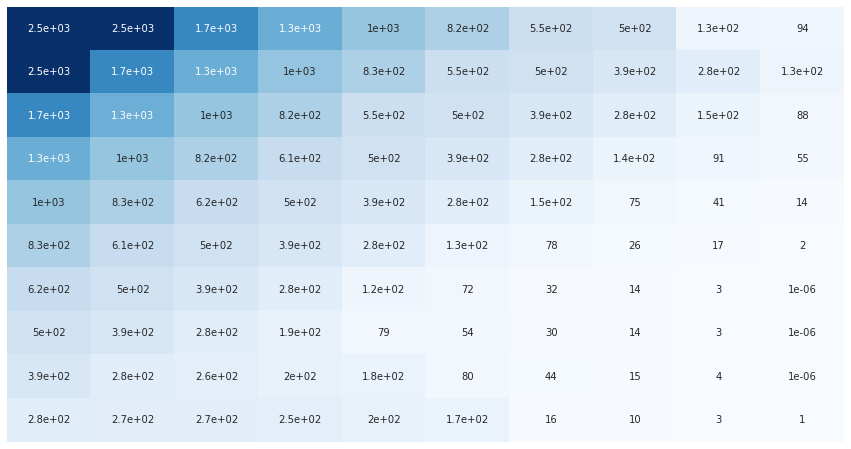

In [16]:
mcts = MCTS(env)
env.get_action(mcts.next_move(state))

plot_value_function(mcts.value_fcn(), env)
plot_value_function(mcts.visitation_fcn(), env)

In [19]:
state = env.reset()
done = False

env.render()
steps = 0
while not done:
    mcts = MCTS(env)
    action = mcts.next_move(state)
    state, reward, done, _ = env.step(action)
    steps += 1

    env.render(save=True, ind=steps)
    # plot_value_function(mcts.value_fcn(), env)
    
create_gif("assets/frozen_lake/step_", steps)

print(f"Success! {steps} moves")

clear_output(wait=True)
plt.clf()
Image(url='assets/solution.gif')  

<Figure size 432x288 with 0 Axes>